# Python projet TP : Machine Learning - Detect'o'Bird

Document réalisé par **Jérémy TREMBLAY** et **Rémi PALISSON** **G7**

## 1 - Introduction

L'objectif de ce projet était de réaliser une classification d'images d'oiseaux.

Un tel projet a un grand intérêt, car il peut être appliqué dans de nombreux cas de figure. En effet il ne s'agit pas d'un concept ayant pour but de faire la distinction entre deux images différentes. Le but ici est de pouvoir déterminer l'espèce d'un oiseau à partir de son image.

Il s'agit d'un projet intéressant et il est possible de lui trouver de nombreuses applications concrètes. On peut imaginer utiliser un tel logiciel dans un Zoo ou dans la nature pour que les gens puissent savoir de quel type d'oiseau il s'agit, simplement à partir d'une photo.

On peut également penser à utiliser un tel logiciel pour sauver les espèces d'oiseaux en voie de disparition, en interdisant la chasse dans les lieux où il sont repérés, ou même simplement pour les passionnés d'ornithologie.

## 2 - Choix des données

Pour mener ce projet à bien, nous avons utilisé Python avec Jupyter afin de créer le notebook que vous êtes en train de lire.

Les différentes images d'oiseaux utilisées pour réaliser ce projet ont été sélectionnées sur [ce dataset trouvé sur Kaggle](https://www.kaggle.com/gpiosenka/100-bird-species)

Attention ce dataset est plutôt lourd (un peu plus de 1G), il contient environ 50 000 images d'oiseaux, réparties en 325 classes différentes (à comprendre qu'une classe d'oiseau = un type d'oiseau). Quelques informations complémentaires sur ce dataset :
* Toutes les images font du `224 * 224 * 3`, et sont en format `jpg`.
* Il y a 47332 images pour l'entrainement (`train`), 1625 images pour les tests (`test`) et 1625 images pour la validation (`valid`), soit 50 582 images au total. Nous n'utiliserons que les images de tests et d'entraînement.
* Chaque dossier contient 325 sous-dossiers, un pour chaque type d'oiseau. 
* Pour `train`, chaque type d'oiseau possède un nombre quelconque d'images, qui diffère en fonction du type de l'oiseau, mais il y a au moins 120 images pour chaque type. Pour les dossiers `test` et `valid`, il y a toujours 5 images par type d'oiseau.
* Le dataset contient un fichier CSV `birds.csv` qui contient 50 582 images, soit autant de lignes que d'images. Pour chaque ligne, on trouve le chemin de l'image, le type de l'oiseau et le dossier correspondant (indiquant si c'est une image de `test`, `train` ou `valid`). Nous allons nous en servir pour charger les images.
* Le dataset contient un autre fichier CSV avec 325 lignes, une classe d'oiseau par ligne, ainsi qu'une dimension (largeur et hauteur, qui sont toujours à `150` et `150`) et une échelle (qui est toujours `1`), qui correspondent aux dimensions et aux échelles utilisées pour faire l'entraînement. Commes toutes les données sont similaires et par soucis de simplicité, nous n'utilisons pas ce fichier.

Pour résumer, maintenant que nous avons les données, nous allons les exploiter. L'objectif final est de donner une image d'un oiseau à notre programme et que celui-ci soit capable d'identifier de quel type d'oiseau il s'agit.

Nous souhaitons obtenir la précision la plus élevée possible.

## 3 - Chargement des données

Il nous maintenant charger nos données pour ensuite pouvoir entraîner nos modèles.

### 3.1 - Préparation

Nous commençons par importer les différents modules et librairies qui seront necessaires à notre programme.

Nous utiliserons `numpy` pour gérer toutes nos données, car elles seront stockées dans des tableaux. `pandas` nous permettera de lire notre fichier CSV et de stocker les données sous forme de DataFrame.

`os` permet de gérer les différents chemins dans l'accès à nos ressources.

`matplotlib` permet de faire l'affichage de figure détaillées, et est très utilisé pour la visualisation des données.

Enfin `PIL` est utilisé pour le chargement des images et `sklearn` pour l'apprentissage et la prédiction des données.

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as im
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
%matplotlib inline
print("Modules loaded")

Modules loaded


Nous commençons par configurer nos chemins d'accès qui seront utilisés pour accéder aux données par tout le reste de notre programme.

Noter qu'il est possible de modifier ces chemins, et si ceux-ci sont corrects, alors le programme devrait fonctionner sans problème.

In [2]:
#The directory where the images are.
BASE_DIR = "../images/"
#The CSV file.
CSV_FILE = "../birds.csv"

#We memorize the different paths needed.
TRAIN_DIR = os.path.join(BASE_DIR, "train/")
VALIDATION_DIR = os.path.join(BASE_DIR, "valid/")
TEST_DIR = os.path.join(BASE_DIR, "test/")

#This directory will be created by the program.
RESIZED_DIR = os.path.join(BASE_DIR, "resized/")

In [3]:
print("The base directory contains these directories : ", os.listdir(BASE_DIR))

The base directory contains these directories :  ['EfficientNetB3-birds-98.40.h5', 'test', 'train', 'Untitled.ipynb', 'images to test', 'valid', '.ipynb_checkpoints']


Nous définissons quelques constantes, notamment la taille de chaque image, la liste de toutes les types d'oiseaux et le nombre de types d'oiseaux :

In [4]:
#The shape of the images
IMAGE_SHAPE = (224, 224, 3)

#We select all types of birds simply by listing all directories
CLASSES = os.listdir(TRAIN_DIR)
NUMBER_OF_CATEGORIES = len(CLASSES)
print("They are", NUMBER_OF_CATEGORIES, "classes in total, which are : ", CLASSES)

They are 325 classes in total, which are :  ['HORNED GUAN', 'MALACHITE KINGFISHER', 'CALIFORNIA CONDOR', 'ANHINGA', 'OSTRICH', 'BROWN CREPPER', 'CRESTED AUKLET', 'PARADISE TANAGER', 'CAPUCHINBIRD', 'CARMINE BEE-EATER', 'FLAME TANAGER', 'CRESTED NUTHATCH', 'WHIMBREL', 'EURASIAN MAGPIE', 'HARLEQUIN DUCK', 'BARN OWL', 'COMMON HOUSE MARTIN', 'CLARKS NUTCRACKER', 'SMITHS LONGSPUR', 'AMERICAN COOT', 'MARABOU STORK', 'GRAY PARTRIDGE', 'DOUBLE BRESTED CORMARANT', 'CALIFORNIA GULL', 'GILA WOODPECKER', 'CAPPED HERON', 'NICOBAR PIGEON', 'SRI LANKA BLUE MAGPIE', 'HYACINTH MACAW', 'TOWNSENDS WARBLER', 'STRIPED OWL', 'EASTERN TOWEE', 'CHESTNET BELLIED EUPHONIA', 'TAIWAN MAGPIE', 'PATAGONIAN SIERRA FINCH', 'ASIAN CRESTED IBIS', 'SCARLET CROWNED FRUIT DOVE', 'HOUSE SPARROW', 'WILSONS BIRD OF PARADISE', 'CURL CRESTED ARACURI', 'NOISY FRIARBIRD', 'PHILIPPINE EAGLE', 'RUBY THROATED HUMMINGBIRD', 'VENEZUELIAN TROUPIAL', 'BORNEAN LEAFBIRD', 'PINK ROBIN', 'COMMON POORWILL', 'NORTHERN GANNET', 'EVENING GROSB

On créé une fonction qui va être responsable de mettre une graîne pour la génération de l'aléatoire. Ainsi cela va nous permettre d'obtenir des résultats similaires, alors qu'ils sont normalement aléatoires.

In [5]:
def set_seed(seed):
    """
    Set the seed af the random and the numpy module.
  
    Parameters:
    seed (int): The seed to set
    
    """
    np.random.seed(seed)
    random.seed(seed)

In [6]:
#We set the seed
set_seed(13)

Nous utilisons une variable pour stocker le nombre de types d'oiseaux qui cont être testés par notre modèle.

Il est important de noter que nous ne pouvons pas tester les 325 types d'oiseaux différents du dataset, cela reviendrait à réaliser un entraînement de plus de 47 000 images. Cela serait très long, et ce n'est même pas possible, car Jupyter n'arriver pas à allouer assez d'espace mémoire pour stocker les données de plus de 50 types d'oiseaux (une erreur est levée). Nous prendrons 15 types d'oiseaux différents comme référence. 

Il est possible de changer ce nombre mais plus il augmentera et plus la précision diminuera, car un plus grand nombre de possibilités pour le programme insinue une plus grande marge d'erreur. Cela est expliqué plus loin, lors de l'entraînement des modèles.

In [7]:
#The number of type of birds that will be use to test our models.
NUMBER_MAX_OF_CLASSES = 15

#We shuffle the classes and we select random types of birds.
random.shuffle(CLASSES)
CLASSES_FOR_LEARNING = CLASSES[:NUMBER_MAX_OF_CLASSES]
print("Types of birds that will be use in the program :", CLASSES_FOR_LEARNING)

Types of birds that will be use in the program : ['KILLDEAR', 'RED FACED CORMORANT', 'WHITE BROWED CRAKE', 'RED BELLIED PITTA', 'MALLARD DUCK', 'SPLENDID WREN', 'CHIPPING SPARROW', 'COMMON GRACKLE', 'AMERICAN GOLDFINCH', 'TOWNSENDS WARBLER', 'INDIAN BUSTARD', 'WHITE TAILED TROPIC', 'RUDY KINGFISHER', 'GRAY CATBIRD', 'SPANGLED COTINGA']


### 3.2 - Chargement du fichier CSV

Nous utilisons ici `pandas` pour lire notre fichier CSV. Il va nous servir à récupérer les chemins d'accès pour chaque image, ainsi que le type d'oiseau correspondant à chaque image.

In [8]:
#We read the CSV file.
df_files = pd.read_csv(CSV_FILE, sep=',')

Nous explorons ensuite les données du fichier.

In [9]:
print(df_files.head())
print("...")
print(df_files.tail(3))

                             filepaths                 labels data set
0  train/AFRICAN CROWNED CRANE/001.jpg  AFRICAN CROWNED CRANE    train
1  train/AFRICAN CROWNED CRANE/002.jpg  AFRICAN CROWNED CRANE    train
2  train/AFRICAN CROWNED CRANE/003.jpg  AFRICAN CROWNED CRANE    train
3  train/AFRICAN CROWNED CRANE/004.jpg  AFRICAN CROWNED CRANE    train
4  train/AFRICAN CROWNED CRANE/005.jpg  AFRICAN CROWNED CRANE    train
...
                                 filepaths                   labels data set
50579  valid/YELLOW HEADED BLACKBIRD/3.jpg  YELLOW HEADED BLACKBIRD    valid
50580  valid/YELLOW HEADED BLACKBIRD/4.jpg  YELLOW HEADED BLACKBIRD    valid
50581  valid/YELLOW HEADED BLACKBIRD/5.jpg  YELLOW HEADED BLACKBIRD    valid


In [10]:
df_files.shape

(50582, 3)

In [11]:
df_files.columns

Index(['filepaths', 'labels', 'data set'], dtype='object')

In [12]:
df_files.info

<bound method DataFrame.info of                                  filepaths                   labels data set
0      train/AFRICAN CROWNED CRANE/001.jpg    AFRICAN CROWNED CRANE    train
1      train/AFRICAN CROWNED CRANE/002.jpg    AFRICAN CROWNED CRANE    train
2      train/AFRICAN CROWNED CRANE/003.jpg    AFRICAN CROWNED CRANE    train
3      train/AFRICAN CROWNED CRANE/004.jpg    AFRICAN CROWNED CRANE    train
4      train/AFRICAN CROWNED CRANE/005.jpg    AFRICAN CROWNED CRANE    train
...                                    ...                      ...      ...
50577  valid/YELLOW HEADED BLACKBIRD/1.jpg  YELLOW HEADED BLACKBIRD    valid
50578  valid/YELLOW HEADED BLACKBIRD/2.jpg  YELLOW HEADED BLACKBIRD    valid
50579  valid/YELLOW HEADED BLACKBIRD/3.jpg  YELLOW HEADED BLACKBIRD    valid
50580  valid/YELLOW HEADED BLACKBIRD/4.jpg  YELLOW HEADED BLACKBIRD    valid
50581  valid/YELLOW HEADED BLACKBIRD/5.jpg  YELLOW HEADED BLACKBIRD    valid

[50582 rows x 3 columns]>

On se rend compte qu'il n'y a aucune ligne de données manquante dans le fichier.

In [13]:
df_files.isna().sum()

filepaths    0
labels       0
data set     0
dtype: int64

Nous allons simplement conserver les lignes qui correspondent aux classes que nous allons tester (comme expliqué précédemment), afin de ne pas charger des images inutilement.

In [14]:
#We just keep the lines corresponding to the birds we have selected for the test.
df_files = df_files[df_files['labels'].isin(CLASSES_FOR_LEARNING)]

In [15]:
NUMBER_OF_IMAGES = df_files.shape[0]
print("At the total, there are ", NUMBER_OF_IMAGES, " images found in the CSV file.")

At the total, there are  2349  images found in the CSV file.


### 3.3 - Chargement des images

Maintenant que le fichier CSV est chargé et que nous avons les types d'oiseaux que nous allons conserver pour nos modèles ainsi que les chemins d'accès à leurs images, nous allons devoir charger toutes les images. Cependant les images sont trop grosses et trop lourdes. Nous allons donc devoir les redimensionner et diminuer leur qualité afin de gagner de l'espace de stockage, mais également de l'espace mémoire pour que notre programme charge et stocke nos données plus facilement.

On commence par définir une fonction qui affiche un temps de chargement :

In [16]:
def display_percentage_work(current, total):
    """
    Display a percentage of work with a print.
  
    Parameters:
    current (float): The current value of the work
    total (float): The total of the work to be done.
    
    """
    percentage = current / total * 100
    #The backslash r is to rewrite something on top of it.
    print("Loading... %", percentage, end='\r')

Nous devons donc sauvegarder les images avec une qualité moindre et une résolution plus faible dans un autre dossier afin de directement charger les images depuis ce dossier-là par la suite.

Nous définissons alors une fonction qui sauvegarde une image, et une autre qui sauvegarde toutes les images :

In [17]:
def save_image(path_src, path_dest, quality=1, verbose=False):
    """
    Save an image from a source path to a destination path by decreasing his quality and shape.
  
    Parameters:
    path_src (str): The source path of the image
    path_dest (str): The destination path of the image.
    quality(int): The quality of the image (default = 1)
    verbose(bool): Use to display some information (default = False)
    
    """
    
    #Open the image and do nothing if it already exists
    image_file = Image.open(path_src)
    if os.path.isfile(path_dest) == True:
        if verbose:
            print("WARNING : file ", path_dest, " already exist and was not overwritted")
        return
    
    directories = path_dest.split('/')
    chain = ""
    #Create the subdirectories from the destination path if they does not exists.
    for directory in directories[:-1]:
        chain = chain + directory + "/"
        if os.path.isdir(chain) == False:
            os.mkdir(chain)
            if verbose:
                print("Directory ", directory, " created.")

    #Save the image with the new quality.
    image_file.save(path_dest, quality = quality)

In [18]:
def save_all_images(df_images, quality=1, verbose=False):
    """
    Save all images from a dataframe.
  
    Parameters:
    df_images (DataFrame): The dataframe which contains the paths of the images.
    quality (int): The quality of the image (default = 1)
    verbose (bool): Used to display some information (default = False)
    
    """
    
    #Iterate through the dataframe and call the save_image function to save each image in a lower resolution.
    for i in range(df_images.shape[0]):
        path = os.path.join(BASE_DIR, df_images.values[i])
        save_image(path, os.path.join(RESIZED_DIR, df_images.values[i]), quality=quality, verbose=verbose)
        #Display the percentage of work done.
        if verbose:
            display_percentage_work(i, NUMBER_OF_IMAGES)

    if verbose:
        print("All images are now saved in a smaller resolution for a fast loading.")
        print("Next time, the loading will be faster.")

Maintenant que nous avons sauvegardé les images en plus basse qualité, il nous faut une fonction pour charger ces images.

Nous devons les charger depuis la `dataframe`, il faut ainsi qu'on précise si l'on veut charger le jeu d'image de `train`, `test` ou `valid`. On réalise une fonction qui va venir faire cela pour nous :

In [19]:
def load_images_from_dataset(df_images, path, dataset="train"):
    """
    Load all the images and classes from a dataFrame with a specific directory which contains in the path passed in parameter,
    and return the data.
  
    Parameters:
    df_images (DataFrame): The dataframe which contains the paths of the images and the classes corresponding.
    path (str): a path that will be added before the path of the images contained in the dataframe.
    dataset (str): The specific dataset that will be read (default = "train")
    
    Returns:
    DataFrame: A dataframe with two columns which contains the images and the classes corresponding.
    
    """
    
    #We create a DataFrame with two columns : an image and the class corresponding.
    df_images_data = pd.DataFrame(columns = ["images", "classes"])
    
    #We use a mask to select only the images that comes from the dataset specify.
    mask = df_images["data set"] == dataset
    
    #We create a Series from the image column by selecting only the paths that come from the dataset specify (by using the mask)
    column = pd.Series([path] * np.count_nonzero(mask) + df_images["filepaths"][mask])
    #We read these images and add them to the DataFrame.
    df_images_data["images"] = column.apply(im.imread)
    
    #We just do the same things with classes, but we don't read images (already done).
    column = pd.Series(df_images["labels"][mask])
    df_images_data['classes'] = column
    
    #We return the data.
    return df_images_data

On réalise une fonction qui va venir charger tous les datasets qui vont nous être utiles. Nous ne nous servirons pas de `valid`, car l'objectif ici est d'entraîner notre modèle avec les données de `train` et de le faire réaliser des tests et des prédictions avec les données de `test`.

Cette fonction retourne juste les deux datasets qui nous serons utiles.

In [20]:
def load_all_datasets(df_images, path, verbose=False):
    """
    Load all datasets from DataFrame, and returns the DataFrame which contains the data.
  
    Parameters:
    df_images (DataFrame): The dataframe which contains the paths of the images and the classes corresponding.
    path (str): a path that will be added before the path of the images contained in the dataframe.
    verbose (bool): A boolean that display some information when passed at True (default = False).
    
    """
    
    if verbose:
        print("Loading images from train...")
    
    #We just load the two datasets usefull for our program, train and test, and return them.
    df_train = load_images_from_dataset(df_images, path, dataset="train")
    
    if verbose:
        print("Loading images from test...")
    df_test = load_images_from_dataset(df_images, path, dataset="test")
    
    if verbose:
        print("Loading finish.")
        
    return df_train, df_test

Maintenant que nous avons les fonctions nous permettant de charger toutes nos données, et que nous avons déjà ouvert notre fichier CSV, il ne nous reste plus qu'à les charger. Pour cela, on vérifie que le dossier des images redimensionnées existe. Si c'est le cas on charge les images depuis ce dossier (ce sera plus rapide), sinon on propose à l'utilisateur de le créer.

S'il refuse on charge les images depuis le dossier par défaut, mais ce sera plus long.

In [21]:
#If the folder was created in the past, we load from this folder.
if (os.path.exists(RESIZED_DIR) == False):
    #Else we ask if the user wants to create another directory and save all images.
    print("No resized folder detected in ", RESIZED_DIR)
    response = input("Do you want to save all images in a smaller format ? Il will take longer this time but next times it will be faster. (y/n)")
    if response == 'y':
        print("We are saving your images in a lower resolution for a faster loading next time")
        save_all_images(df_files, quality=1, verbose=True)
        #Load data.
        df_train, df_test = load_all_datasets(df_files, RESIZED_DIR, verbose=True)
    else:
        df_train, df_test = load_all_datasets(df_files, BASE_DIR, verbose=True)
else:
    df_train, df_test = load_all_datasets(df_files, RESIZED_DIR, verbose=True)

No resized folder detected in  ../images/resized/
Do you want to save all images in a smaller format ? Il will take longer this time but next times it will be faster. (y/n)n
Loading images from train...
Loading images from test...
Loading finish.


Maintenant nous avons normalement chargé toutes nos images, et nous avons la correspondance entre une image et sa classe.

                                      Image  <---------------> type d'oiseau
                          
Nous allons maintenant essayer de visualiser nos données pour s'assurer qu'elles sont chargées.

## 4 - Visualisation des données

Commençons par s'assurer des dimensions des données contenues danc chacune de nos `DataFrame`. Normalement, elles doivent chacune contenir un certain de nombre de lignes, et deux colonnes. La première colonne correspond à l'image, et la seconde correspond à la classe, c'est à dire, au type d'oiseau.

In [22]:
print(df_train.shape)
print(df_test.shape)

(2199, 2)
(75, 2)


Pour visualiser nos données, nous allons les afficher, étant donné qu'il s'agit d'images. Nous utilisons `matplotlib` pour afficher des images d'oiseaux avec leurs noms au-dessus.

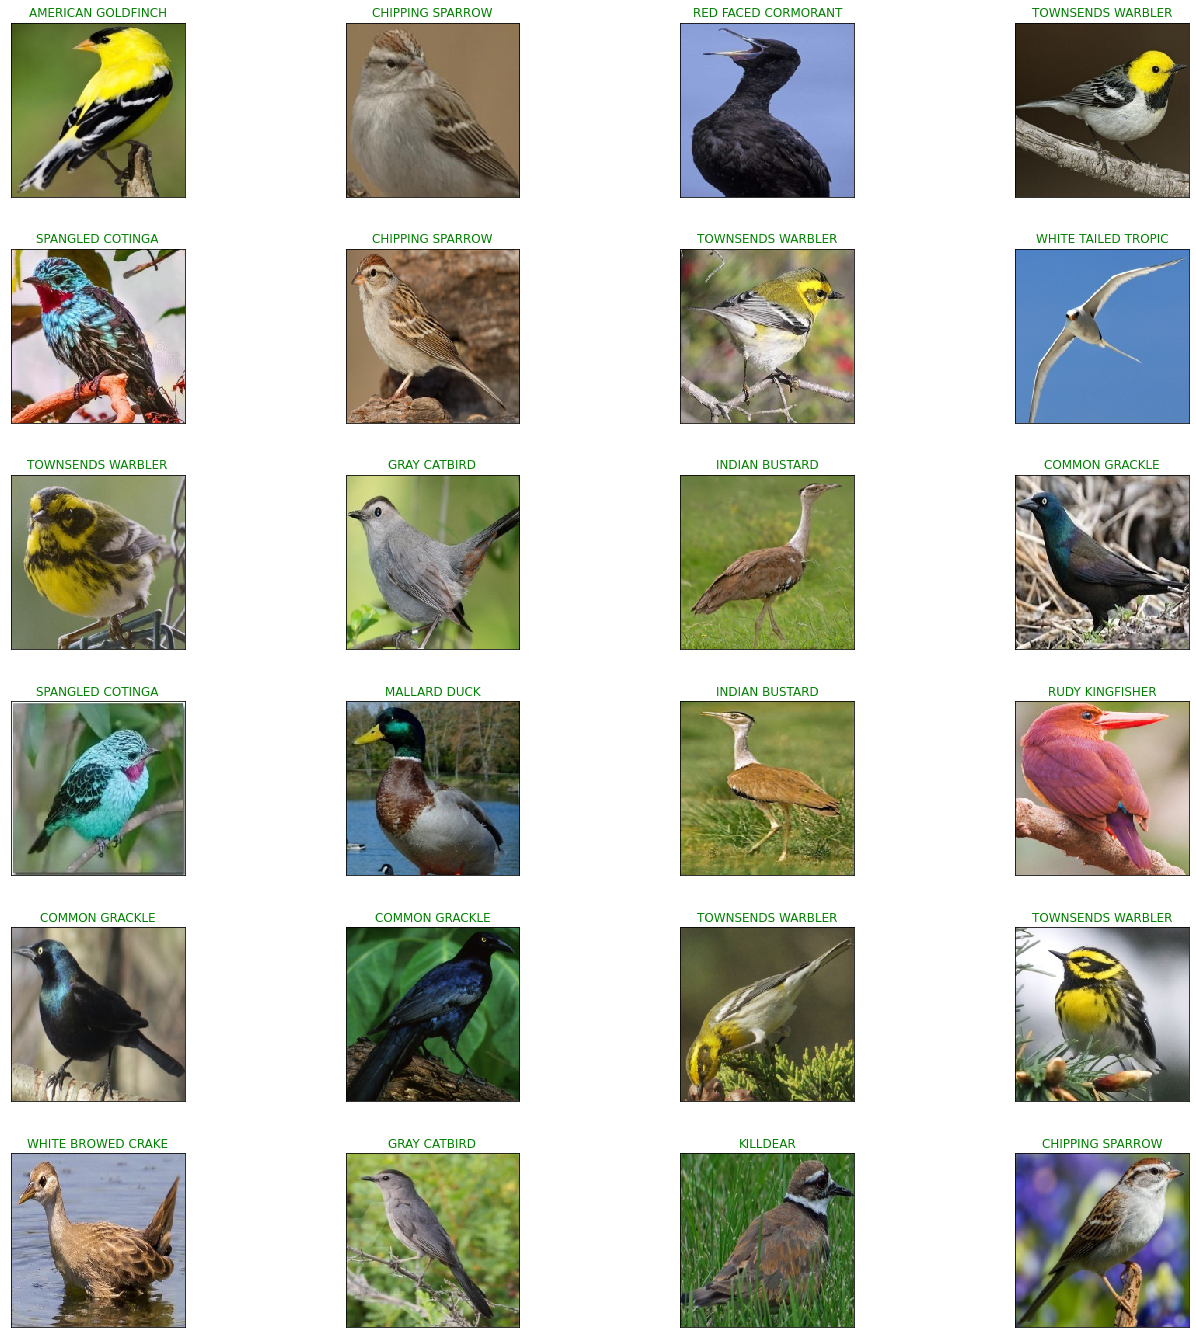

In [23]:
#Here we just randomize the rows in the dataframe, but we keep the association image <-> class.
df_train_random_copy = df_train.sample(frac=1).reset_index(drop=True)

#We create a figure.
fig, axes = plt.subplots(6, 4, figsize=(24, 24), 
                        subplot_kw = {'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.3, wspace=0))

#for each ax, we display an image with the class for the title.
for i, ax in enumerate(axes.flat):
    ax.imshow(df_train_random_copy['images'][i], cmap='binary', interpolation='nearest')
    ax.set_title(df_train_random_copy['classes'][i], color='green')
    
#Display the figure.
plt.show()   

Nos données sont bien chargées, nous allons maintenant passer aux toutes dernières préparations avant d'entraîner nos modèles.

## 5 - Préparations

Nous avons nos données, et nous sommes presques prêts à entraîner nos modèles. Pour pouvoir le faire, il nous faut un jeu de test et un jeu d'entraînement. Nous n'avons pas besoin d'utiliser `train_test_split` de `sklearn` qui sépare un jeu de donnée en données de test et d'entraînement, car nous avons déjà deux `DataFrame` avec nos données de `test` et de `train`, car le dataset que nous avons utilisé séparaît déjà les deux jeux de données.

In [24]:
print(df_train['images'].head)

<bound method NDFrame.head of 1082     [[[118, 144, 73], [117, 143, 72], [116, 142, 7...
1083     [[[121, 124, 81], [121, 124, 81], [120, 126, 8...
1084     [[[255, 255, 255], [255, 255, 255], [255, 255,...
1085     [[[118, 121, 64], [124, 127, 74], [139, 137, 8...
1086     [[[78, 93, 36], [79, 94, 37], [78, 96, 38], [7...
                               ...                        
46251    [[[95, 173, 247], [95, 173, 247], [96, 174, 24...
46252    [[[112, 137, 193], [112, 137, 193], [112, 137,...
46253    [[[93, 121, 171], [93, 121, 171], [91, 119, 16...
46254    [[[72, 71, 77], [50, 49, 55], [47, 46, 51], [4...
46255    [[[107, 132, 163], [108, 133, 164], [110, 135,...
Name: images, Length: 2199, dtype: object>


Pour le moment, nos images sont contenues sous forme de listes imbriquées les unes dans les autres (dans la `DataFrame`), mais `skelearn` a besoin d'un tableau à une seule dimension. Il nous faut donc *aplatir* les images. 

In [25]:
def flat_images(images):
    """
    Flat the images from a Series.
  
    Parameters:
    images (Series): The Series which contains the images.

    Returns:
    ndarray: A numpy array which contains a collection of flat images.
    
    """
    
    #Create an empty array with dimensions of the future array.
    copy = np.empty((len(images), IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]))
    i = 0
    
    #Iterate the Series and reshape all image, then add them to the new array.
    for image in images:
        arr = np.array(image).reshape(IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2])
        copy[i] = arr
        i = i + 1
    
    #Return the new array.
    return copy

Il nous faut également mélanger nos données, car pour le moment, tous les mêmes types d'oiseaux se trouvent les uns à la suite des autres dans nos `DataFrame`. 

In [26]:
print("Train : ", df_train['classes'], "\n")
print("Test : ", df_test['classes'])

Train :  1082      AMERICAN GOLDFINCH
1083      AMERICAN GOLDFINCH
1084      AMERICAN GOLDFINCH
1085      AMERICAN GOLDFINCH
1086      AMERICAN GOLDFINCH
                ...         
46251    WHITE TAILED TROPIC
46252    WHITE TAILED TROPIC
46253    WHITE TAILED TROPIC
46254    WHITE TAILED TROPIC
46255    WHITE TAILED TROPIC
Name: classes, Length: 2199, dtype: object 

Test :  47367     AMERICAN GOLDFINCH
47368     AMERICAN GOLDFINCH
47369     AMERICAN GOLDFINCH
47370     AMERICAN GOLDFINCH
47371     AMERICAN GOLDFINCH
                ...         
48917    WHITE TAILED TROPIC
48918    WHITE TAILED TROPIC
48919    WHITE TAILED TROPIC
48920    WHITE TAILED TROPIC
48921    WHITE TAILED TROPIC
Name: classes, Length: 75, dtype: object


On voit bien que tous les mêmes types d'oiseaux se suivent (c'est pareil pour les images). Considérons deux jeux de `test` et de `train` ci-dessous : 

##### Jeu 1
`Train` : 🐔 🐔 🐔 🐔 🕊️ 🕊️ 🕊️ 🕊️ 🦅 🦅 🦅 🦅 🦩 🦩 🦩 🦩 🦜 🦜 🦜 🦜 🦢 🦢 🦢 🦢  
`Test` : 🐔 🐔 🕊️ 🕊️ 🦅 🦅 🦩 🦩 🦜 🦜 🦢 🦢

##### Jeu 2
`Train` : 🐔 🦩 🦩 🐔 🦜 🦢 🐔 🦅 🦅 🕊️ 🐔 🕊️ 🦅 🦩 🦜 🕊️ 🦢 🦢 🕊️ 🦅 🦩 🦜 🦜 🦢  
`Test` : 🦢 🐔 🦩 🦜 🦩 🕊️ 🕊️ 🦅 🐔 🦜 🦢 🦅

Nous avons bien les mêmes oiseaux, les mêmes jeux de données, ils sont simplement mélangés.

Or un modèle à plus de chance de mieux performer avec des données mélangées. Cela ne signifie pas qu'un modèle va forcément avoir une meilleure précision si les données sont mélangées, mais c'est ce qu'il se passe en théorie dans la vrai vie. En général, on fournit plusieurs photos de types d'oiseaux différents, on ne donne pas 150 photos de tel type d'oiseau, puis 140 d'un autre oiseau. 

On essaye au maximum de mélanger pour entraîner notre modèle à chercher dans toutes les données qu'il possède. Si les 140 première photos qu'il récupère sont des photos d'oiseaux du même type, alors il ne peut peut pas s'entraîner à différencier un autre type d'oiseau vu qu'il ne connaît que lui pour l'instant. Si les 140 premières photos proviennent de 60 types d'oiseaux différents, alors il aura un vrai effort de sélection à faire.

Encore une fois, le mélange ne signifie pas que nous allons avoir de meilleurs scores de réussite, mais c'est le plus souvent dans ces conditions que l'on vient entraîner des modèles. Nous allons donc mélanger nos deux `DataFrame` en préservant la correspondance entre l'image et le type de l'oiseau.

In [27]:
df_train_mixed = df_train.sample(frac=1).reset_index(drop=True)
df_test_mixed = df_test.sample(frac=1).reset_index(drop=True)

On peut maintenant charger toutes nos données qui vont nous servir pour l'apprentissage de nos modèles. Nous avons besoin de `X_train` et `y_train` qui correspondent respectivement aux images et aux résultat attendus de l'entraînement de nos modèles.

`X_test` et `y_test` sont necessaires pour l'entraînement de notre modèle et pour qu'il puisse nous fournir une prédiction de résultats. On récupère directement ces données depuis les `DataFrame` précédentes.

In [28]:
X_train = flat_images(df_train_mixed['images'])
y_train = np.array(df_train_mixed['classes'])
X_test = flat_images(df_test_mixed['images'])
y_test = np.array(df_test_mixed['classes'])

print(y_test.shape)
print(y_train.shape)
print(X_test.shape)
print(X_train.shape)

(75,)
(2199,)
(75, 150528)
(2199, 150528)


On peut s'assurer que les données sont bien mélangées. Bien sûr, il est impossible de reconnaître les images ici, mais on voit bien que les classes d'oiseaux ne se suivent pas comme auparavant.

In [29]:
print(X_train[:4])
print(y_train[:4])
print(X_test[:4])
print(y_test[:4])

[[161. 153. 104. ... 166. 149. 119.]
 [156. 147. 130. ... 144. 140. 103.]
 [125. 147.  83. ... 247. 231. 215.]
 [185. 208. 242. ...  13.  13.  13.]]
['KILLDEAR' 'SPLENDID WREN' 'KILLDEAR' 'COMMON GRACKLE']
[[ 85.  81.  44. ...  80.  87.  71.]
 [158. 169. 113. ...  75.  99.   1.]
 [173. 162. 132. ... 117. 179. 204.]
 [ 54.  68.  32. ... 134. 169. 136.]]
['SPANGLED COTINGA' 'WHITE BROWED CRAKE' 'TOWNSENDS WARBLER'
 'GRAY CATBIRD']


Les images sont donc maintenant bien toutes sur une seule ligne et mélangées. Nous allons pouvoir passer à l'apprentissage. Mais avant cela il nous reste une dernière chose à faire, nous devons nous assurer que nous n'avons pas trop de différence de répartition entre nos données de test et d'entraînement. Si une classe possède un faible nombre de données d'entraînement (images) par rapport aux autres classes, alors nos modèles auront plus de mal à la reconnaître.

Il est important d'avoir une répartition plus ou moins uniforme pour s'assurer que nos données ne sont pas biaisées, ou ne favorisent pas certains types d'oiseaux. On créé une fonction affichant un histogramme permettant de visualiser la répartition des données.

In [30]:
def plot_differences_test_train(data, location="left"):
    """
    Display a bar chart representing the difference between the repartition of the data.
  
    Parameters:
    data (nparray): A numpy array which contains data.
    location (str): The location where to display the bar (left or right) (default = "left").

    """
    
    #Set a position in function of the location.
    if location == "left":
        position = -0.5
    else:
        position = 0.5
        
    space = 0.40
    
    #Get an array of unique names (no duplicates), and the number of each name.
    unique_names, numbers = np.unique(data, return_counts=True)
    index = np.argsort(unique_names)
    unique_names = unique_names[index]

    #Calculate the percentage of apparition of each name in the data.
    percentages = 100 * numbers[index] / len(data)

    #Get a list of indexes.
    indexes = np.arange(len(unique_names))

    #Add the bars on the chart.
    plt.bar(indexes + position * space, percentages, align='center', width=space)
    
    #Add the names
    plt.xticks(indexes, unique_names, rotation=50)
    
    #Add the labels on x and y.
    plt.xlabel("Type of bird")
    plt.ylabel("% number")

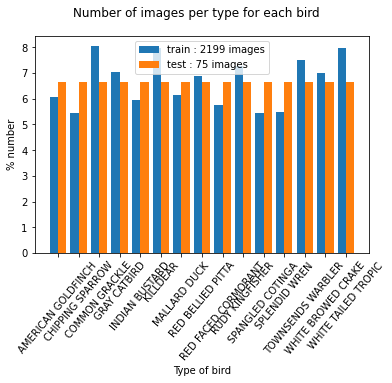

In [31]:
#We plot the figure by calling our function two times : for the train data, and for the test data
plt.suptitle("Number of images per type for each bird")
plot_differences_test_train(y_train, location="left")
plot_differences_test_train(y_test, location="right")

#Add a small legend in the top right corner.
plt.legend(["train : " + str(len(y_train)) + " images", 
            "test : " + str(len(y_test)) + " images"]);
plt.show()

Nous voyons bien que les données de test sont bien respectées, puisque pour chaque type d'oiseau nous avons 5 images de test. Les données d'entraînements varient un peu plus, mais aucune n'est spécialement majoritaire ou minoritaire. Il n'y a pas une vraie différence et une vrai démarcation entre les différentes espèces.

Nous pouvons donc passer à l'entraînement de nos modèles et aux prédictions.

## 6 - Entraînement des modèles et prédictions

Nous allons maintenant créer des modèles, les entraîner avec les données d'entraînement et leur demander de faire des prédictions avec les données de test. Voici plus en détail comment cela fonctionne :
* On crée notre modèle.
* On commence par entraîner notre modèle en lui fournissant le `X_train` et le `y_train`. En interne il va s'entraîner et faire des predictions depuis le `X_train` (autrement dit, il essaye de prédire des types d'oiseaux depuis les images), puis ensuite il va vérifier s'il avait juste ou pas pour chaque prediction par rapport à la vrai valeur (le type d'oiseau juste qui se trouve dans `y_train`).
* Une fois le modèle entrainé, on peut lui faire effectuer des prédictions. Pour cela on lui donne simplement `X_test` (les images que l'on veut tester), et il va effectuer des prédiction pour chaque image, autrement dit, il va essayer d'associer un type d'oiseau à chaque image.
* On obtient alors un `y_predict` qui contient les types d'oiseaux prédits pour chaque image, et on peut comparer chaque valeur de ce `y_predic` avec le `y_test`. Ainsi plus il y a d'écart entre les deux et moins le modèle est performant.
* On peut ensuite analyser les résultats et la précision (matrice de confusion, rapport détaillé...)

Au total, nous allons nous attader ici sur 3 modèles différents, tous issus de sklearn, mais nous en utiliserons une dizaine au total. Chaque modèle à ses spécificités et ils ne nous donneront pas de résultats identiques, certains seront plus pertinents que d'autres. Nous allons commencer par entraîner un premier modèle, assez connu, qui se nomme l'arbre de décision.

### 6-1 L'arbre de décision

La spécificité de ce modèle est qu'on peut le visualiser sous la forme d'un arbre binaire. Un noeud racine possède des noeux fils (2 au maximum), et ainsi de suite. Les noeuds sans enfants s'appellent des feuilles. On peut facilement parcourir ce graphe. L'avantage de ce modèle est qu'il est très visuel mais devient vite très gros et complexe au fur et à mesure qu'on l'entraîner, car il crée toujours plus de noeuds.

On commence par créer notre modèle. On spécifie qu'on veut lui donner une profondeur maximale de 10 noeuds, à savoir que plus cette valeur augmente, plus précis sera notre modèle, mais le temps d'execution sera plus long. On entraîne ensuite notre modèle en lui donnant notre jeu d'entraînement composé des images et des classes associées.

In [32]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=10)
clf_decision_tree = decision_tree.fit(X_train, y_train)

Notre modèle est entrainé et il est possible de visualiser l'arbre qui a été généré lors de l'entraînement. A noter que si un grand nombre de types d'oiseaux est sélectionné, il est possible que le graphe ci-dessous devienne illisible.

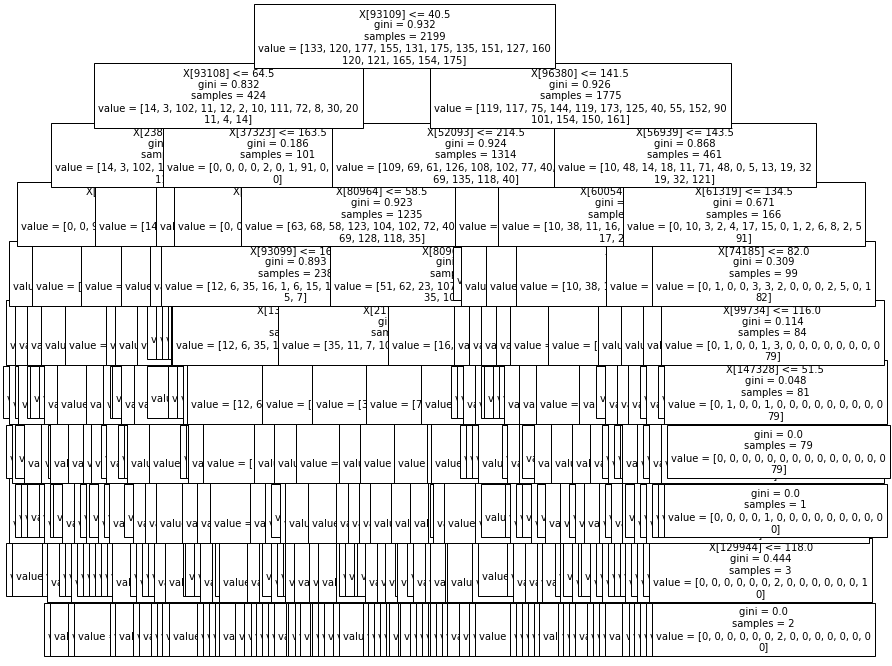

In [33]:
#We maximize the size of the figure.
plt.figure(figsize=(12,12))
plot_tree(clf_decision_tree, fontsize=10)
plt.show()

On peut maintenant lui faire effectuer des prédictions. Pour cela on lui envoie notre jeu de test et on récupère les prédictions qu'il a calculé, il s'agit des types d'oiseaux associés aux images.

In [34]:
y_prediction_decision_tree = clf_decision_tree.predict(X_test)

Pour afficher la fiabilité de notre algorithme, on peut utiliser l'accuracy score qui est souvent la métrique la plus adapaté. Elle mesure le niveau de fiabilité de notre algorithme, le pourcentage (enfin probabilité) de bonnes prédictions de notre algorithme. Il est possible de la calculer manuellement mais on peut simplement utiliser les outils que nous propose sklearn :

In [35]:
accuracy_score(y_test, y_prediction_decision_tree)

0.4

Dans notre cas à nous, nous avons 0.4 de probabilité de bonnes réponses, soit 40%. Cette probabilité est plutôt moyenne, mais nous avons 15 classes d'oiseaux différentes tout de même. Bien évidemment cette probabilité peut varier en fonction des types d'oiseaux sélectionnés. On peut analyser plus en profondeur les résultats qu'un simple pourcentage de bonnes réponses. Pour cela, on peut utiliser la matrice de confusion pour analyser où notre modèle s'est trompé, où il a eu juste, etc.

In [36]:
print(confusion_matrix(y_test, y_prediction_decision_tree))

[[1 0 0 0 1 1 0 0 0 1 0 0 1 0 0]
 [0 1 0 0 1 1 0 0 0 1 0 0 0 1 0]
 [0 0 2 0 0 0 1 0 0 0 1 0 1 0 0]
 [0 0 0 2 1 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 2 0 0 0 0 1 0 0 0 2 0]
 [0 0 0 0 1 2 0 0 0 0 1 0 1 0 0]
 [0 0 1 0 1 0 2 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 2 0 1 0 0 0 0]
 [0 1 0 0 0 1 1 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 4 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 2 1 0 0 1]
 [1 0 0 1 1 0 0 0 0 0 0 0 2 0 0]
 [0 1 0 0 1 1 0 0 0 0 1 0 0 1 0]
 [1 0 0 0 0 0 1 0 0 0 0 1 0 0 2]]


Cette matrice est en réalité un gros résumé des résultats de prédictions sur notre problème. La diagonale qui passe du point en haut à gauche jusqu'à en bas à droite correspond aux prédictions correctes. Les autres cases sont des prédictions incorrectes. La somme de chaque ligne doit alors correspondre au nombre d'images de test pour chaque catégorie d'oiseau. Ainsi il faudrait idéalement avoir "5" (le nombre d'image de test pour chaque type d'oiseau) dans chaque case de la diagonale, cela signifierait que l'on a 100% de fiabilité et de bonnes prédictions.

Ici ce n'est pas le cas mais on reconnaît une diagonale principale. Il est même possible de vérifier pour quels types d'oiseaux le programme s'est trompé. Pour avoir un rendu plus propre, nous créons une fonction permettant d'afficher une matrice de confusion normalisée, la somme de chaque ligne faisant "1".


In [37]:
def draw_confusion_matrix(y_test, predictions, title="Confusion Matrix"):
    """
    Display a chart representing a confusion matrix.
  
    Parameters:
    y_test (nparray): A numpy array which contains the real predictions.
    predictions (nparray): A numpy array which contains the predictions from the model.
    title (str): A title for the chart (dafault="Confusion Matrix")

    """
    #We get the confusion matrix.
    matrix = confusion_matrix(y_test, predictions)
    #We normalize the lines because we wants a probability between 0 and 1
    matrix = matrix / matrix.astype(np.float).sum(axis=1)
    #We display the matrix with a title.
    disp = ConfusionMatrixDisplay(matrix)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_title(title, fontsize=30)
    disp.plot(ax=ax)
    plt.show()

On peut maintenant afficher la matrice :

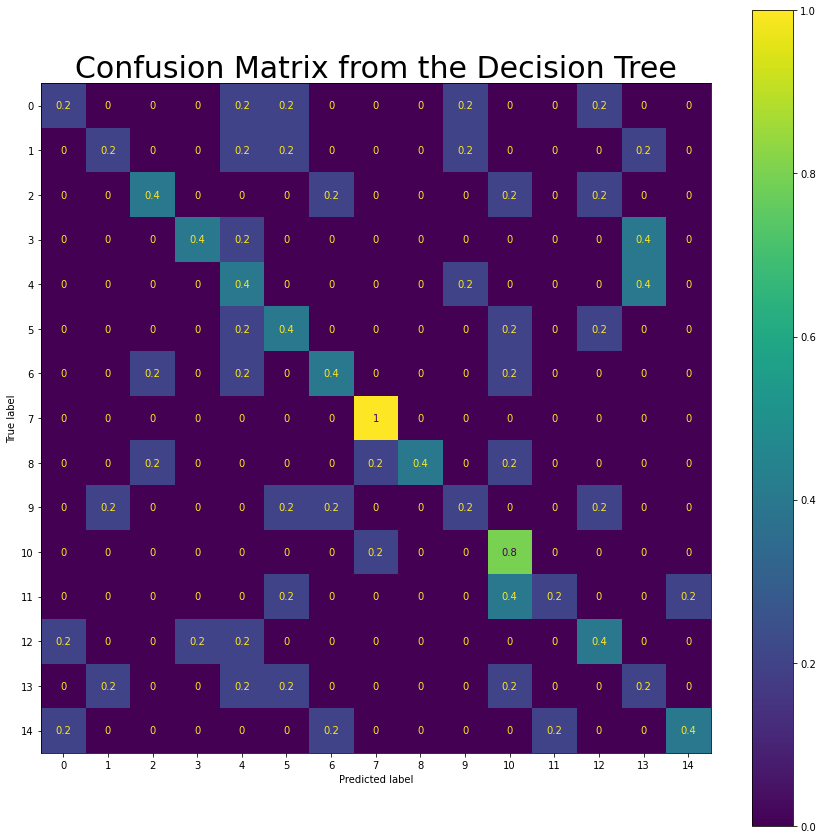

In [38]:
draw_confusion_matrix(y_test, y_prediction_decision_tree, "Confusion Matrix from the Decision Tree")

Le rendu est déjà plus joli et plus reconnaissable. Il est possible d'analyser que le modèle n'arrive pas à détecter les types d'oiseaux pour les lignes qui ont 0 de précision sur la diagonale. Cela signifie qu'aucune des 5 images n'a été identifiée comme étant bien le bon type d'oiseau, qu'il y a probablement un gros problème dans la détection d'image si aucun des 5 oiseaux n'a été détecté.

Pour finir, nous pouvons terminer l'analyse de ces résultats par l'utilisation d'un rapport de la classification.

In [39]:
print(classification_report(y_test, y_prediction_decision_tree))

                     precision    recall  f1-score   support

 AMERICAN GOLDFINCH       0.33      0.20      0.25         5
   CHIPPING SPARROW       0.33      0.20      0.25         5
     COMMON GRACKLE       0.50      0.40      0.44         5
       GRAY CATBIRD       0.67      0.40      0.50         5
     INDIAN BUSTARD       0.22      0.40      0.29         5
           KILLDEAR       0.29      0.40      0.33         5
       MALLARD DUCK       0.40      0.40      0.40         5
  RED BELLIED PITTA       0.71      1.00      0.83         5
RED FACED CORMORANT       1.00      0.40      0.57         5
    RUDY KINGFISHER       0.25      0.20      0.22         5
   SPANGLED COTINGA       0.36      0.80      0.50         5
      SPLENDID WREN       0.50      0.20      0.29         5
  TOWNSENDS WARBLER       0.33      0.40      0.36         5
 WHITE BROWED CRAKE       0.17      0.20      0.18         5
WHITE TAILED TROPIC       0.67      0.40      0.50         5

           accuracy   

Ce rapport très détaillé permet d'obtenir de plus amples informations sur la fiabilité de notre classifieur, bien plus précisemment qu'avec l'`accuracy_score`. Pour cela, regardons un peu plus en détail. 

Chaque ligne correspond à un type d'oiseau que notre modèle à évalué. Le `support` correspond au nombre d'images pour chaque type, ici nous sommes toujours à 5 car nous avons à chaque fois 5 images de test par type d'oiseau. La colonne `precision` indique combien de fois les images ont bien été correctement classifiées. La colonne `recall` indique combien d'images de cette classe ont été trouvées. La dernière colonne `f1-score` est une harmonisation des deux colonnes précédentes. Les données sont ensuite harmonisées et affichées sous forme de probabilités, mais l'idée reste la même.

Ainsi la colonne `f1-score` permet d'évaluer la reconnaissance de chaque type d'oiseau dans sa globalité. Plus une valeur est élevée et plus cette classe est détectée facilement par le modèle, et il se trompe rarement dessus. Ainsi les classes avec de faibles valeurs signifient probablement que le modèle manque de données et d'images associées à ces types. Il faudrait ajouter plus d'images aux types d'oiseaux qui ont une faible valeur de `f1-score`.

Pour finir nous affichons quelques oiseaux avec les prédictions pour chaque oiseau : en rouge si notre modèle s'est trompé et en vert s'il a eu juste, cela permet de mieux se rendre compte visuellement du travail qu'il a effectué plutôt que de simples données textuelles.

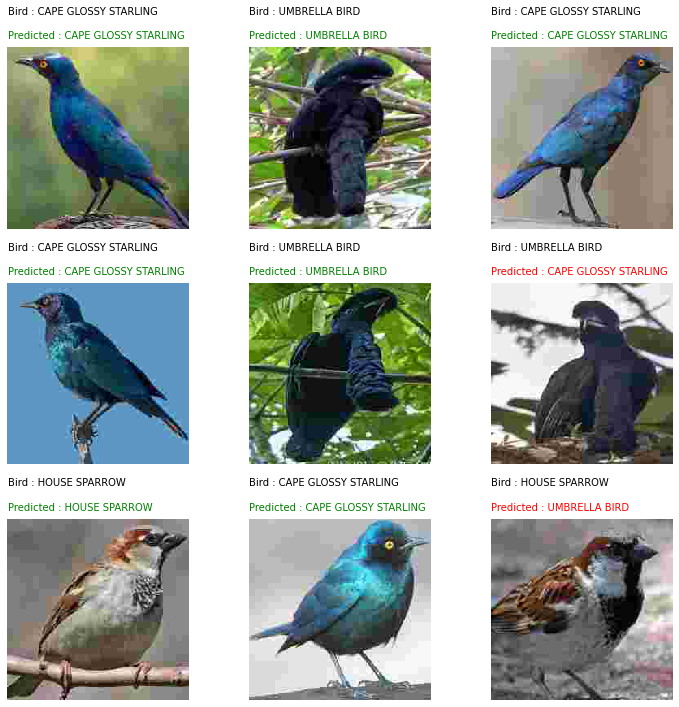

In [52]:
#We create a figure to show the predictions vs the real classes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), 
                         subplot_kw = {'xticks':[], 'yticks':[]}, 
                         gridspec_kw=dict(hspace=0.3, wspace=0.3))

#Iterate though the axes and the data
for ax, image, prediction, real in zip(axes.flat, X_test, y_prediction_decision_tree, y_test):
    ax.set_axis_off()
    #Show image.
    ax.imshow(image.reshape(224, 224, 3).astype(np.uint8), interpolation="nearest")
    ax.text(0, -45, "Bird : " + real, va='center', ha='left')
    #Change the color in function of the prediction.
    if (prediction == real):
        ax.text(0, -15, "Predicted : " + prediction, color="green", va='center', ha='left')
    else:
        ax.text(0, -15, "Predicted : " + prediction, color="red", va='center', ha='left')

plt.show()

### 6.2 - Entraînement et comparaison de plusieurs modèles

Nous venons de voir un modèle en particulier, mais nous allons ici en tester plusieurs afin de les comparer entre eux.

Pour cela, nous allons organiser une petite liste de différents modèles de classification. Nous allons associer un nom à chaque modèle pour pouvoir les retrouver plus facilement.

In [90]:
models = [
    "DTC", DecisionTreeClassifier(random_state=0, max_depth=10),
    "KNN", KNeighborsClassifier(),
    "SVC", svm.SVC(),
    "RFC", RandomForestClassifier(n_estimators=10),
    "MLP", MLPClassifier(activation='identity', learning_rate_init=.1, verbose=False),

    "MNB", MultinomialNB(),
    "GNB", GaussianNB(),
    "ABC", AdaBoostClassifier(),
    "SGDC", SGDClassifier(),
    "QDA", QuadraticDiscriminantAnalysis()
]

Une solution serait de parcourir chaque modèle et de l'entraîner, puis de le tester et voir son `accuracy_score`. Nous allons ensuite analyser les deux modèles avec le plus gros `accuracy_score` (même si nous avons vus que précédemment qu'un modèle n'était pas forcément mauvais à cause d'un `accuracy_score` faible, cela dépend d'autres facteurs, nous allons ici baser notre sélection sur ce résultat pour chaque modèle).

Bien évidemment, les résultats vont varier en fonction des modèles et du nombre de types d'oiseaux sélectionnés car chaque modèle est plus adapté dans certains contexte plutôt que dans d'autres. C'est justement le but ici de les comparer, nous analyserons le meilleur. Cela ne signifie pas que le meilleur modèle présenté ici est le meilleur dans tous les cas, loin de là.

In [91]:
#We will save the predictions, the name, and the accuracy for each model for later
predictions_list = []
names = []
accuracy_scores = []

#Iterate though the models, train them, make predictions and display some usefull information.
for name, model in zip(models[0::2], models[1::2]):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    names.append(name)
    predictions_list.append(predictions)
    accuracy_scores.append(accuracy)
    print("Model ", name, " has an accuracy of ", accuracy)

Model  DTC  has an accuracy of  0.4
Model  KNN  has an accuracy of  0.36
Model  SVC  has an accuracy of  0.72
Model  RFC  has an accuracy of  0.5733333333333334
Model  MLP  has an accuracy of  0.6666666666666666
Model  MNB  has an accuracy of  0.6133333333333333
Model  GNB  has an accuracy of  0.52
Model  ABC  has an accuracy of  0.25333333333333335
Model  SGDC  has an accuracy of  0.7066666666666667


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Model  QDA  has an accuracy of  0.10666666666666667


Une fois que nous sommes en possession des performance de chaque modèle, nous pouvons aisément comparer les résultats. Dans ce cas-ci, il semblerait que notre meilleure score soit réalisé par SVM, avec un `accuracy_score` de 0.76.

Il est simple de construire un graphe permettant de visualiser le niveau d'`accuracy_score` réalisé par chaque modèle.

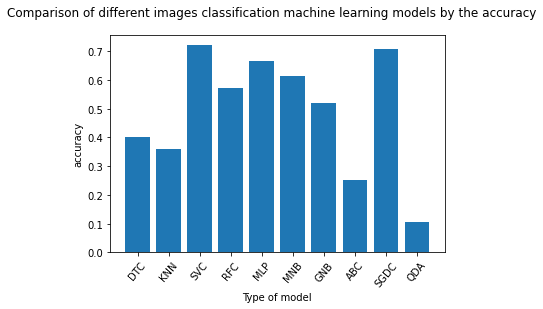

In [93]:
plt.suptitle("Comparison of different images classification machine learning models by the accuracy")
indexes = range(len(names))

#Add the bars on the chart.
plt.bar(indexes, accuracy_scores, align='center')

#Add the names of classifiers
plt.xticks(indexes, names, rotation=50)

#Add the labels on x and y.
plt.xlabel("Type of model")
plt.ylabel("accuracy")

plt.show()

Il est beaucoup plus aisé de cette manière de voir le meilleur modele, lorsqu'on se base uniquement sur l'`accuracy_score`. Ici le meilleur semble être SVC, mais SGDC et MLP ne sont pas loin derrière.

Nous allons donc essayer de tester un modèle qui semble intéressant, c'est pourquoi nous allons analyser plus en détails le modèle SVC.

### 6.3 - Le modèle SVC

Le modèle SVC semble particulièrement pertinent à analyser plus en profondeur, c'est pourquoi nous allons ici essayer de comprendre son fonctionnement.

Il faut noter que le modèle SVC utilise un système de vecteurs pour regrouper les données qui partagent des points communs. Il regroupe les points similaires et établit des vecteurs qui viennent délimiter ces ensembles de points, et ces vecteurs viennent alors déterminer les différentes classes de notre programme.

De la même manière que précédemment, nous pouvons générer notre modèle, l'entrainer et lui faire faire des tests sur nos données :

In [95]:
svc = svm.SVC()
clf_svc = svc.fit(X_train, y_train)

On lui fait prédire notre jeu de tests :

In [99]:
y_prediction_svc = clf_svc.predict(X_test)

Matrice de confusion :

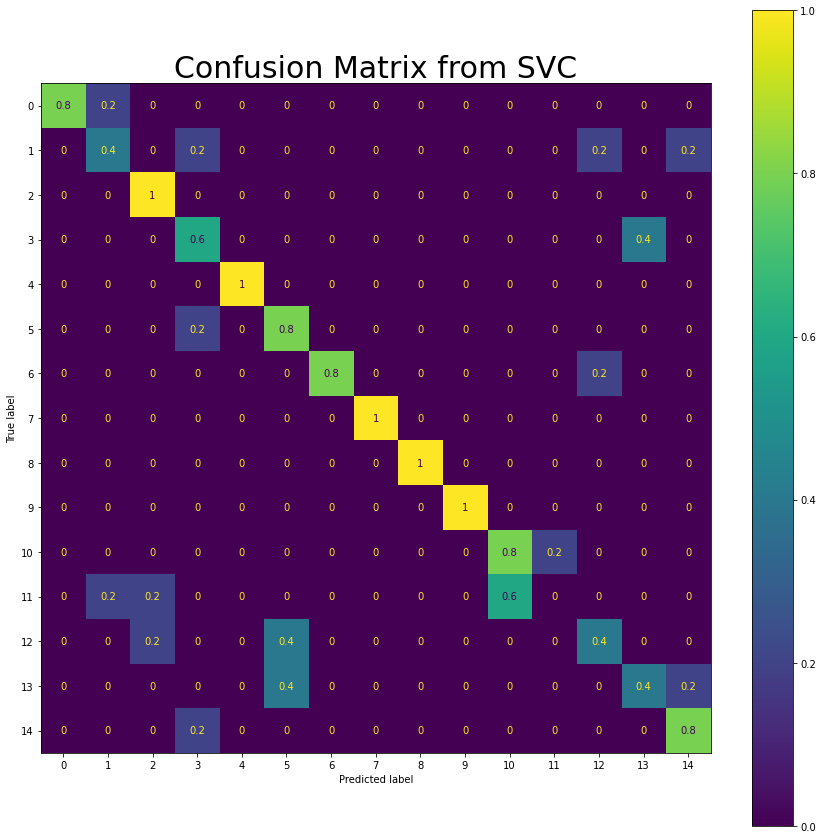

In [101]:
draw_confusion_matrix(y_test, y_prediction_svc, "Confusion Matrix from SVC")

Nous pouvons afficher le rapport détaillé :

In [102]:
print(classification_report(y_test, y_prediction_svc))

                     precision    recall  f1-score   support

 AMERICAN GOLDFINCH       1.00      0.80      0.89         5
   CHIPPING SPARROW       0.50      0.40      0.44         5
     COMMON GRACKLE       0.71      1.00      0.83         5
       GRAY CATBIRD       0.50      0.60      0.55         5
     INDIAN BUSTARD       1.00      1.00      1.00         5
           KILLDEAR       0.50      0.80      0.62         5
       MALLARD DUCK       1.00      0.80      0.89         5
  RED BELLIED PITTA       1.00      1.00      1.00         5
RED FACED CORMORANT       1.00      1.00      1.00         5
    RUDY KINGFISHER       1.00      1.00      1.00         5
   SPANGLED COTINGA       0.57      0.80      0.67         5
      SPLENDID WREN       0.00      0.00      0.00         5
  TOWNSENDS WARBLER       0.50      0.40      0.44         5
 WHITE BROWED CRAKE       0.50      0.40      0.44         5
WHITE TAILED TROPIC       0.67      0.80      0.73         5

           accuracy   

Nous pouvons voir à travers ce modèle qu'il semble beaucoup plus fiable que l'arbre de décision. En effet, la matrice de confusion affiche une diagonale presque parfaite, et on voit sur le rapport que ce modèle gère plutôt bien la classification des images, mais il a tendance à plus détecter certains types d'oiseaux. Globalement les résultats sont plutôt bons même si je suis sûr qu'ils pourraient être optimisés.

## 7 - Conclusion

En conclusion, nous pouvons retenir que nous avons preparé toutes nos données, que nous les avons organisées, visualisées, puis que nous avons crée nos modèles et comparés plusieurs modèles différents. Nous nous somems attardés sur l'arbre de décision et SVC qui nous ont donné des bons résultats après analyse des données. Il reste encore beaucoup de choses à faire et de modèles à explorer, cela commence par l'optimisation (il est possible d'augmenter la précision), mais on pourrait tester en profondeur bien d'autres choses (redimensionnements d'images, effets...).

Nous espérons que ce Notebook vous a plu.

Jérémy TREMBLAY - Rémi PALISSON